In [22]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [23]:

# Loop through each file name
def load_dataset(image_dir, label):
    file_names = os.listdir(image_dir)

    images = []
    for file_name in file_names:
        # Construct the full path to the image file
        file_path = os.path.join(image_dir, file_name)

        # Load the image using OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was successfully loaded
        if image is not None:
            # Append the image to the list
            images.append(image)

    images = np.array(images)
    images = images/255

    rows = 1
    cols = 5
    c = 1
    # for i in range (0,5):
    #     plt.subplot(rows, cols, c)
    #     c+=1
    #     plt.imshow(images[i], plt.get_cmap('gray'))

    # plt.show()

    images = images.reshape(images.shape[0], -1)

    y_train = images.shape[0]*[ label ]
    y_train = np.array(y_train)

    return [images, y_train]


[x_train_0, y_train_0] = load_dataset("./Dataset/Non_Demented", 0 )
[x_train_1, y_train_1] = load_dataset("./Dataset/Very_Mild_Demented", 1)
[x_train_2, y_train_2] = load_dataset("./Dataset/Mild_Demented", 2)
[x_train_3, y_train_3] = load_dataset("./Dataset/Moderate_Demented", 3)

class_dict = {"Non_Demented": y_train_0.shape[0], "Very_Mild_Demented": y_train_1.shape[0], "Mild_Demented": y_train_2.shape[0], "Moderate_Demented": y_train_3.shape[0]}


X = np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3 ))
Y = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3 ))


indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indices]
Y = Y[indices]

print(X.shape, Y.shape)

X_train = X[: int(X.shape[0] * 0.80)]
Y_train = Y[: int(X.shape[0] * 0.80)]

X_val = X[int(X.shape[0] * 0.80) : int(X.shape[0] * 0.90)]
Y_val = Y[int(Y.shape[0] * 0.80) : int(Y.shape[0] * 0.90)]

X_test = X[int(X.shape[0] * 0.90) : ]
Y_test = Y[int(X.shape[0] * 0.90) : ]

print(f"x test: {X_train.shape}")
print(f"x validation: {X_val.shape}")
print(f"x test: {X_test.shape}")




(6400, 16384) (6400,)
x test: (5120, 16384)
x validation: (640, 16384)
x test: (640, 16384)


Text(0.5, 1.0, 'Distribution of Alzheimer MRI Images')

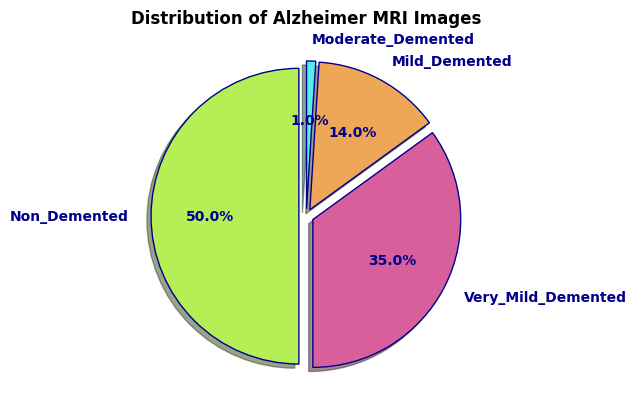

In [24]:
# pie char for classes
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
keys = list(class_dict.keys())
values = list(class_dict.values())
explode = (0.05,)*len(keys)

labels = [f'{key}' for key in keys]

plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 10, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
        {'edgecolor':'darkblue'} , labeldistance=1.15)
plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold")



In [25]:
# having coorelation between all the dimensions in the dataset

# X_train_df = pd.DataFrame(X_train)

# # Calculate the correlation matrix for X_train
# correlation_matrix = X_train_df.corr()
# max_value_less_than_1 = correlation_matrix[correlation_matrix < 1].max().max()
# print("Maximum value less than 1 in the DataFrame:", max_value_less_than_1)




#  PCA for the dataset
# too low accuracy - 21% . doesnt make sense.. dusra algo dekhna padega
def calculate_pca(p):

    pca = PCA(n_components=p)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)

    # applying QDA to find thhe accuracy corresponding to the dimensionality reduction

    # qda = QuadraticDiscriminantAnalysis()
    # qda.fit(X_train_pca, Y_train)
    # Y_pred = qda.predict(X_test_pca)

    # # Calculate the accuracy
    # accuracy = accuracy_score(Y_test, Y_pred)
    # print("Accuracy after QDA on dimensionaly reduced dataset:", accuracy)
    return X_train_pca, X_test_pca, X_val_pca

#  taking PCA (p= 100), as it is the closest to the total accuracy without dimensional reduction
X_train , X_test, X_val= calculate_pca(100)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(5120, 100)
(640, 100)
(640, 100)


Validation Accuracy:  0.6546875
Test accuracy:  0.6265625


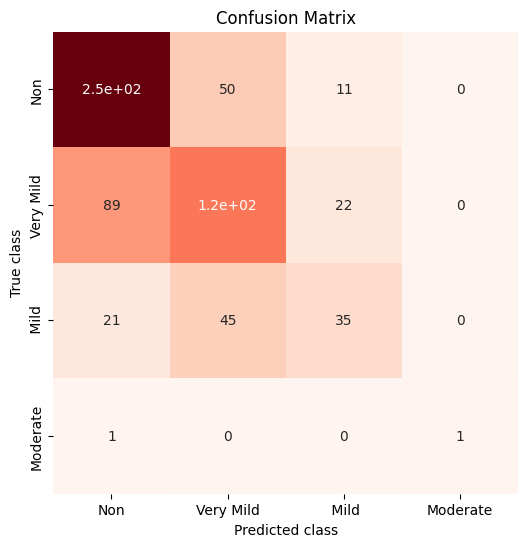

In [26]:
# Model1: Multiclass Logistic Regression (Accuracy  = 67.3% )
log_reg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=2000)
log_reg.fit(X_train, Y_train)

validation_accuracy = log_reg.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = log_reg.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)


# for the test set calculaitng the recall = no of true positives / total no of positives = no of true positives / no of true positives + no of false negatives
y_pred = log_reg.predict(X_test)
conf_matrix = confusion_matrix(Y_test, y_pred)

classes =['Non', 'Very Mild', ' Mild', 'Moderate' ]
plt.figure(figsize = (6,6), facecolor=(1,1,1,0))
sns.heatmap(conf_matrix, annot=True, cmap = 'Reds', cbar = False,
xticklabels=classes , yticklabels=classes)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix")
plt.show()





In [27]:
# decision tree model - used cross validation to get the max depth to be choosen - (Accuracy = 73.125 %)

param_grid = {'max_depth': [25, 50 , 100]}
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')  # cross validation
grid_search.fit(X_train, Y_train)

best_depth = grid_search.best_params_['max_depth']
print(best_depth)

best_decision_tree = grid_search.best_estimator_


validation_accuracy = best_decision_tree.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = best_decision_tree.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)


25
Validation Accuracy:  0.7296875
Test accuracy:  0.6921875


In [28]:
# random forest
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

random_forest = RandomForestClassifier(n_estimators = 75)
random_forest.fit(X_combined, Y_combined)


test_accuracy = random_forest.score(X_test, Y_test)
print("Test Accuracy: ", test_accuracy)





Test Accuracy:  0.9375


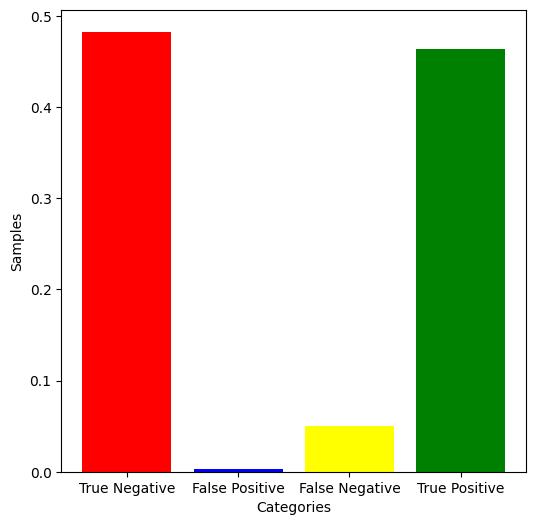

In [29]:
# considering very-mild, mild and moderate to be positive and non-demented to be negative
Y_pred = random_forest.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

tn = conf_matrix[0][0] / Y_test.shape[0]
fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / Y_test.shape[0]
fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / Y_test.shape[0]
tp = 0

for i in range(1,4):
    for j in range(1,4):
        tp += conf_matrix[i][j]
tp = tp / Y_test.shape[0]

plt.figure(figsize=(6,6))
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [tn, fp, fn, tp]


plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
plt.xlabel('Categories')
plt.ylabel('Samples')
plt.show()
